In [19]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\janlu\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [20]:
pip install numpy scipy tqdm

You should consider upgrading via the 'C:\Users\janlu\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [7]:
import h5py
import os
import glob
import h5py
import numpy as np

from scipy.stats import zscore
from scipy.signal import find_peaks

import matplotlib.pyplot as plt

from scipy.stats import binned_statistic
from scipy.signal import find_peaks
from scipy.optimize import curve_fit 
from scipy.signal import convolve2d

#@title Dimensionality Reduction using PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import emd.sift as sift
import emd.spectra as spectra

import pingouin as pg
import sails
import scipy.io as sio
from scipy.io import loadmat
import pandas as pd


In [8]:
def bin_tf_to_fpp(x, power, bin_count):
    if x.ndim == 1:  # Handle the case when x is of size (2)
        bin_ranges = np.arange(x[0], x[1], 1)
        fpp = binned_statistic(bin_ranges, power[:, x[0]:x[1]], 'mean', bins=bin_count)[0]
        fpp = np.expand_dims(fpp, axis=0)  # Add an extra dimension to match the desired output shape
    elif x.ndim == 2:  # Handle the case when x is of size (n, 2)
        fpp = []
        for i in range(x.shape[0]):
            bin_ranges = np.arange(x[i, 0], x[i, 1], 1)
            fpp_row = binned_statistic(bin_ranges, power[:, x[i, 0]:x[i, 1]], 'mean', bins=bin_count)[0]
            fpp.append(fpp_row)
        fpp = np.array(fpp)
    else:
        raise ValueError("Invalid size for x")

    return fpp

# The get_rem_states function takes in an array of sleep states and the sample rate of the data.
def get_rem_states(states, sample_rate):
    """
    Extract consecutive REM (Rapid Eye Movement) sleep states and their start
    and end times from an array of sleep states.

    Parameters:
    - states (numpy.ndarray): One-dimensional array of sleep states.
    - sample_rate (int): The sample rate of the data.

    Returns:
    numpy.ndarray: An array containing start and end times of consecutive REM
    sleep states. Each row represents a pair of start and end times.

    Note:
    - Sleep states are represented numerically. In this function, REM sleep
      states are identified by the value 5 in the 'states' array.

    Example:
    ```python
    import numpy as np

    # Example usage:
    sleep_states = np.array([1, 2, 5, 5, 5, 3, 2, 5, 5, 4, 1])
    sample_rate = 2500  # Example sample rate in Hz
    rem_states_times = get_rem_states(sleep_states, sample_rate)
    print(rem_states_times)
    ```
    """
    try:
        # Ensure the sleep states array is one-dimensional.
        states = np.squeeze(states)
        # Find the indices where the sleep state is equal to 5, indicating REM sleep.
        rem_state_indices = np.where(states == 5)[0]
        
        # Check if there are no REM states. If so, return an empty array.
        if len(rem_state_indices) == 0:
            return np.array([])
        # Calculate the changes between consecutive REM state indices.
        rem_state_changes = np.diff(rem_state_indices)
        # Find the indices where consecutive REM states are not adjacent.
        split_indices = np.where(rem_state_changes != 1)[0] + 1
        # Add indices to split consecutive REM states, including the start and end indices.
        split_indices = np.concatenate(([0], split_indices, [len(rem_state_indices)]))
        # Create an empty array to store start and end times of consecutive REM states.
        consecutive_rem_states = np.empty((len(split_indices) - 1, 2))
        # Iterate through the split indices to extract start and end times.
        for i, (start, end) in enumerate(zip(split_indices, split_indices[1:])):
            start = rem_state_indices[start] * int(sample_rate)
            end = rem_state_indices[end - 1] * int(sample_rate)
            consecutive_rem_states[i] = np.array([start, end])
        # Convert the array to a numpy array.
        ##consecutive_rem_states = np.array(consecutive_rem_states)
        # Create a mask to filter out consecutive REM states with negative duration.
        null_states_mask = np.squeeze(np.diff(consecutive_rem_states) > 0)
        consecutive_rem_states = consecutive_rem_states[null_states_mask]
        # Return the array containing start and end times of consecutive REM states.
        return consecutive_rem_states
    # Handle the case where an IndexError occurs, typically due to an empty array.
    except IndexError as e:
        print(f"An IndexError occurred in get_rem_states: {e}")
        return np.array([])  # or any default value you want


# This function computes the Morlet wavelet transform of a given signal.
# It uses the SAILS library to perform the wavelet transform.
def morlet_wt(x, sample_rate, frequencies=np.arange(1, 200, 1), n=5, mode='complex'):
    """
    Compute the Morlet wavelet transform of a given signal using the SAILS library.

    Parameters:
    - x (numpy.ndarray): The input signal.
    - sample_rate (int): The rate at which the signal is sampled.
    - frequencies (numpy.ndarray, optional): The array of frequencies at which to compute the transform
      (default is from 1 to 200 Hz).
    - n (int, optional): The number of cycles in the Morlet wavelet (default is 5).
    - mode (str, optional): The mode of the return, whether 'complex', 'power', or 'amplitude'
      (default is 'complex').
      
    Returns:
    - numpy.ndarray: The computed Morlet wavelet transform of the input signal.

    Note:
    - This function relies on the SAILS library to perform the wavelet transform.

    Example:
    ```python
    import numpy as np

    # Example usage:
    signal = np.sin(2 * np.pi * 10 * np.arange(0, 1, 1/sample_rate))
    wt_result = morlet_wt(signal, sample_rate)
    print(wt_result)
    ```
    """
    wavelet_transform = sails.wavelet.morlet(x, freqs=frequencies, sample_rate=sample_rate, ncycles=n,
                                             ret_mode=mode, normalise=None)
    # Return the computed wavelet transform.
    return wavelet_transform


# The tg_split function categorizes frequency values into three groups: sub-theta, theta, and supra-theta.
def tg_split(mask_freq, theta_range=(5, 12)):
    """
    Categorize frequency values into three groups: sub-theta, theta, and supra-theta.

    Parameters:
    - mask_freq (numpy.ndarray): An array of frequency values that you want to categorize.
    - theta_range (tuple, optional): A range of frequencies considered as the theta band
      (default is (5, 12) Hz).

    Returns:
    - tuple: A tuple containing three boolean masks representing sub-theta, theta, and supra-theta categories.

    Example:
    ```python
    import numpy as np

    # Example usage:
    freq_values = np.array([3, 8, 10, 15, 20])
    sub_mask, theta_mask, supra_mask = tg_split(freq_values)
    print("Sub-theta frequencies:", freq_values[sub_mask])
    print("Theta frequencies:", freq_values[theta_mask])
    print("Supra-theta frequencies:", freq_values[supra_mask])
    ```
    """
    # Get the lower and upper bounds of the theta range.
    lower = np.min(theta_range)
    upper = np.max(theta_range)
    # Create a boolean mask for frequencies within the theta range.
    mask_index = np.logical_and(mask_freq >= lower, mask_freq < upper)
    # Create boolean masks for frequencies below and above the theta range.
    sub_mask_index = mask_freq < lower
    supra_mask_index = mask_freq > upper
    # Assign the boolean masks to variables for each category.
    sub = sub_mask_index
    theta = mask_index
    supra = supra_mask_index
    # Return the boolean masks for sub-theta, theta, and supra-theta categories.
    return sub, theta, supra

# This function finds the indices where a signal crosses zero.
# x: The input signal.
def zero_cross(x):
    """
    Find the indices where a signal crosses zero.

    Parameters:
    - x (numpy.ndarray): The input signal.

    Returns:
    - numpy.ndarray: An array containing the indices where the input signal crosses zero.

    Example:
    ```python
    import numpy as np

    # Example usage:
    signal = np.array([1, -2, 3, -1, 0, 2, -4, 5])
    zero_cross_indices = zero_cross(signal)
    print("Zero-crossing indices:", zero_cross_indices)
    ```
    """
    # Identify where the signal goes from positive to non-positive (decay).
    decay = np.logical_and((x > 0)[1:], ~(x > 0)[:-1]).nonzero()[0]
    # Identify where the signal goes from non-positive to positive (rise).
    rise = np.logical_and((x <= 0)[1:], ~(x <= 0)[:-1]).nonzero()[0]
    # Combine the indices of rise and decay, then sort them with ascending indices.
    zero_xs = np.sort(np.append(rise, decay))
    # Return the sorted indices where the signal crosses zero.
    return zero_xs

# This function identifies the zero crossings, peaks, and troughs in a signal.
def extrema(x):
    """
    Identify the zero crossings, peaks, and troughs in a signal.

    Parameters:
    - x (numpy.ndarray): The input signal.

    Returns:
    - tuple: A tuple containing three arrays - zero-crossing indices, trough indices, and peak indices.

    Example:
    ```python
    import numpy as np

    # Example usage:
    signal = np.array([1, -2, 3, -1, 0, 2, -4, 5])
    zero_crossings, trough_indices, peak_indices = extrema(signal)
    print("Zero-crossing indices:", zero_crossings)
    print("Trough indices:", trough_indices)
    print("Peak indices:", peak_indices)
    ```
    """
    # Find the indices where the signal crosses zero.
    zero_xs = zero_cross(x)
    # Initialize empty arrays to store peak and trough indices.
    peaks = np.empty((0,)).astype(int)
    troughs = np.empty((0,)).astype(int)
    # Iterate through pairs of consecutive zero crossings.
    for t1, t2 in zip(zero_xs, zero_xs[1:]):
        # Find the index of the maximum absolute value in the current segment.
        extrema0 = np.argmax(np.abs(x[t1:t2])).astype(int) + t1
        # Check if the value at the found index is positive (peak) or non-positive (trough).
        if bool(x[extrema0] > 0):
            peaks = np.append(peaks, extrema0)
        else:
            troughs = np.append(troughs, extrema0)
    # Return the indices of zero crossings, troughs, and peaks.
    return zero_xs, troughs, peaks

Processing file: E:\Donders\1\processed\CN\post_trial1_2017-09-28_11-30-59\post_trial1_2017-09-28_11-30-59_REM_dict.h5
Available groups: ['post_trial1_2017-09-28_11-30-59']
(212501, 6)
shape power matrix: (125, 212501)
shape of fpp_plots (610, 125, 19)
(125, 610)
fpp_list length: 1
Processing file: E:\Donders\1\processed\CN\post_trial2_2017-09-28_12-21-41\post_trial2_2017-09-28_12-21-41_REM_dict.h5
Available groups: ['post_trial2_2017-09-28_12-21-41']
(157501, 6)
shape power matrix: (125, 157501)
shape of fpp_plots (416, 125, 19)
(125, 416)
fpp_list length: 2
Processing file: E:\Donders\1\processed\CN\post_trial3_2017-09-28_13-12-53\post_trial3_2017-09-28_13-12-53_REM_dict.h5
Available groups: ['post_trial3_2017-09-28_13-12-53']
(52501, 6)
shape power matrix: (125, 52501)
shape of fpp_plots (147, 125, 19)
(125, 147)
fpp_list length: 3
(145001, 6)
shape power matrix: (125, 145001)
shape of fpp_plots (388, 125, 19)
(125, 388)
fpp_list length: 4
(47501, 6)
shape power matrix: (125, 47501)

shape power matrix: (125, 277501)
shape of fpp_plots (770, 125, 19)
(125, 770)
fpp_list length: 52
(467501, 6)
shape power matrix: (125, 467501)
shape of fpp_plots (1366, 125, 19)
(125, 1366)
fpp_list length: 53
(220001, 6)
shape power matrix: (125, 220001)
shape of fpp_plots (633, 125, 19)
(125, 633)
fpp_list length: 54
(440001, 6)
shape power matrix: (125, 440001)
shape of fpp_plots (1269, 125, 19)
(125, 1269)
fpp_list length: 55
(42501, 6)
shape power matrix: (125, 42501)
shape of fpp_plots (114, 125, 19)
(125, 114)
fpp_list length: 56
Processing file: E:\Donders\1\processed\OD\post_trial4_2017-09-21_13-40-22\post_trial4_2017-09-21_13-40-22_REM_dict.h5
Available groups: ['post_trial4_2017-09-21_13-40-22']
(465001, 6)
shape power matrix: (125, 465001)
shape of fpp_plots (1292, 125, 19)
(125, 1292)
fpp_list length: 57
(527501, 6)
shape power matrix: (125, 527501)
shape of fpp_plots (1452, 125, 19)
(125, 1452)
fpp_list length: 58
Processing file: E:\Donders\1\processed\OD\post_trial5_2

shape power matrix: (125, 50001)
shape of fpp_plots (134, 125, 19)
(125, 134)
fpp_list length: 105
(412501, 6)
shape power matrix: (125, 412501)
shape of fpp_plots (1147, 125, 19)
(125, 1147)
fpp_list length: 106
(297501, 6)
shape power matrix: (125, 297501)
shape of fpp_plots (863, 125, 19)
(125, 863)
fpp_list length: 107
(195001, 6)
shape power matrix: (125, 195001)
shape of fpp_plots (425, 125, 19)
(125, 425)
fpp_list length: 108
(447501, 6)
shape power matrix: (125, 447501)
shape of fpp_plots (1255, 125, 19)
(125, 1255)
fpp_list length: 109
(45001, 6)
shape power matrix: (125, 45001)
shape of fpp_plots (120, 125, 19)
(125, 120)
fpp_list length: 110
(190001, 6)
shape power matrix: (125, 190001)
shape of fpp_plots (531, 125, 19)
(125, 531)
fpp_list length: 111
(105001, 6)
shape power matrix: (125, 105001)
shape of fpp_plots (309, 125, 19)
(125, 309)
fpp_list length: 112
(337501, 6)
shape power matrix: (125, 337501)
shape of fpp_plots (981, 125, 19)
(125, 981)
fpp_list length: 113
(10

shape power matrix: (125, 182501)
shape of fpp_plots (195, 125, 19)
(125, 195)
fpp_list length: 157
Processing file: E:\Donders\3\processed\Rat_OS_Ephys_Rat3_SD1_OR_08-09_11_2017\post_trial5_2017-11-08_16-18-24\post_trial5_2017-11-08_16-18-24_REM_dict.h5
Available groups: ['post_trial5_2017-11-08_16-18-24']
(37501, 6)
shape power matrix: (125, 37501)
shape of fpp_plots (50, 125, 19)
(125, 50)
fpp_list length: 158
(25001, 6)
shape power matrix: (125, 25001)
shape of fpp_plots (47, 125, 19)
(125, 47)
fpp_list length: 159
(277501, 6)
shape power matrix: (125, 277501)
shape of fpp_plots (388, 125, 19)
(125, 388)
fpp_list length: 160
(245001, 6)
shape power matrix: (125, 245001)
shape of fpp_plots (537, 125, 19)
(125, 537)
fpp_list length: 161
(117501, 6)
shape power matrix: (125, 117501)
shape of fpp_plots (116, 125, 19)
(125, 116)
fpp_list length: 162
(45001, 6)
shape power matrix: (125, 45001)
shape of fpp_plots (62, 125, 19)
(125, 62)
fpp_list length: 163
(20001, 6)
shape power matrix: 

shape of fpp_plots (922, 125, 19)
(125, 922)
fpp_list length: 199
Processing file: E:\Donders\3\processed\Rat_OS_Ephys_Rat3_SD6_HC_23_11_2017\post_trial4_2017-11-23_13-24-05\post_trial4_2017-11-23_13-24-05_REM_dict.h5
Available groups: ['post_trial4_2017-11-23_13-24-05']
(365001, 6)
shape power matrix: (125, 365001)
shape of fpp_plots (234, 125, 19)
(125, 234)
fpp_list length: 200
(60001, 6)
shape power matrix: (125, 60001)
shape of fpp_plots (57, 125, 19)
(125, 57)
fpp_list length: 201
(102501, 6)
shape power matrix: (125, 102501)
shape of fpp_plots (38, 125, 19)
(125, 38)
fpp_list length: 202
(95001, 6)
shape power matrix: (125, 95001)
shape of fpp_plots (37, 125, 19)
(125, 37)
fpp_list length: 203
Processing file: E:\Donders\3\processed\Rat_OS_Ephys_Rat3_SD6_HC_23_11_2017\post_trial5_2017-11-23_14-14-20\post_trial5_2017-11-23_14-14-20_REM_dict.h5
Available groups: ['post_trial5_2017-11-23_14-14-20']
(405001, 6)
shape power matrix: (125, 405001)
shape of fpp_plots (602, 125, 19)
(125

shape power matrix: (125, 190000)
shape of fpp_plots (496, 125, 19)
(125, 496)
fpp_list length: 250
(55000, 6)
shape power matrix: (125, 55000)
shape of fpp_plots (138, 125, 19)
(125, 138)
fpp_list length: 251
(150000, 6)
shape power matrix: (125, 150000)
shape of fpp_plots (347, 125, 19)
(125, 347)
fpp_list length: 252
(310000, 6)
shape power matrix: (125, 310000)
shape of fpp_plots (887, 125, 19)
(125, 887)
fpp_list length: 253
(242500, 6)
shape power matrix: (125, 242500)
shape of fpp_plots (544, 125, 19)
(125, 544)
fpp_list length: 254
(40000, 6)
shape power matrix: (125, 40000)
shape of fpp_plots (78, 125, 19)
(125, 78)
fpp_list length: 255
Processing file: E:\Donders\4\processed\OD\presleep_2017-12-21_11-48-07\presleep_2017-12-21_11-48-07_REM_dict.h5
Available groups: ['presleep_2017-12-21_11-48-07']
Processing file: E:\Donders\4\processed\Rat_OS_Ephys_Rat4_SD2_HC_13_12_2017\post_trial1_2017-12-13_09-11-31\post_trial1_2017-12-13_09-11-31_REM_dict.h5
Available groups: ['post_trial

(480000, 6)
shape power matrix: (125, 480000)
shape of fpp_plots (1201, 125, 19)
(125, 1201)
fpp_list length: 302
(95000, 6)
shape power matrix: (125, 95000)
shape of fpp_plots (219, 125, 19)
(125, 219)
fpp_list length: 303
(165000, 6)
shape power matrix: (125, 165000)
shape of fpp_plots (396, 125, 19)
(125, 396)
fpp_list length: 304
(282500, 6)
shape power matrix: (125, 282500)
shape of fpp_plots (679, 125, 19)
(125, 679)
fpp_list length: 305
(75000, 6)
shape power matrix: (125, 75000)
shape of fpp_plots (172, 125, 19)
(125, 172)
fpp_list length: 306
(47500, 6)
shape power matrix: (125, 47500)
shape of fpp_plots (91, 125, 19)
(125, 91)
fpp_list length: 307
Processing file: E:\Donders\4\processed\Rat_OS_Ephys_Rat4_SD3_OR_11-12_12_2017\presleep_2017-12-14_09-23-18\presleep_2017-12-14_09-23-18_REM_dict.h5
Available groups: ['presleep_2017-12-14_09-23-18']
Processing file: E:\Donders\4\processed\Rat_OS_Ephys_Rat4_SD4_OR_N_18-19_12_2017\post_trial1_2017-12-18_10-28-46\post_trial1_2017-12-1

shape power matrix: (125, 442500)
shape of fpp_plots (1224, 125, 19)
(125, 1224)
fpp_list length: 352
(80000, 6)
shape power matrix: (125, 80000)
shape of fpp_plots (230, 125, 19)
(125, 230)
fpp_list length: 353
(180000, 6)
shape power matrix: (125, 180000)
shape of fpp_plots (487, 125, 19)
(125, 487)
fpp_list length: 354
(165000, 6)
shape power matrix: (125, 165000)
shape of fpp_plots (466, 125, 19)
(125, 466)
fpp_list length: 355
Processing file: E:\Donders\9\processed\2018_06_23_study_day14_OR+SD&NOV\2018-06-23_10-01-45_Pre-sleep\2018-06-23_10-01-45_Pre-sleep_REM_dict.h5
Available groups: ['2018-06-23_10-01-45_Pre-sleep']
Processing file: E:\Donders\9\processed\2018_06_23_study_day14_OR+SD&NOV\2018-06-23_10-52-05_Post_Trial1\2018-06-23_10-52-05_Post_Trial1_REM_dict.h5
Available groups: ['2018-06-23_10-52-05_Post_Trial1']
Processing file: E:\Donders\9\processed\2018_06_23_study_day14_OR+SD&NOV\2018-06-23_11-42-23_Post_Trial2\2018-06-23_11-42-23_Post_Trial2_REM_dict.h5
Available group

shape power matrix: (125, 57500)
shape of fpp_plots (104, 125, 19)
(125, 104)
fpp_list length: 389
(52500, 6)
shape power matrix: (125, 52500)
shape of fpp_plots (148, 125, 19)
(125, 148)
fpp_list length: 390
(342500, 6)
shape power matrix: (125, 342500)
shape of fpp_plots (885, 125, 19)
(125, 885)
fpp_list length: 391
(17500, 6)
shape power matrix: (125, 17500)
shape of fpp_plots (46, 125, 19)
(125, 46)
fpp_list length: 392
(55000, 6)
shape power matrix: (125, 55000)
shape of fpp_plots (120, 125, 19)
(125, 120)
fpp_list length: 393
(155000, 6)
shape power matrix: (125, 155000)
shape of fpp_plots (378, 125, 19)
(125, 378)
fpp_list length: 394
(82500, 6)
shape power matrix: (125, 82500)
shape of fpp_plots (200, 125, 19)
(125, 200)
fpp_list length: 395
Processing file: E:\Donders\9\processed\CN\2018-05-11_12-55-28_Post_Trial3\2018-05-11_12-55-28_Post_Trial3_REM_dict.h5
Available groups: ['2018-05-11_12-55-28_Post_Trial3']
(262500, 6)
shape power matrix: (125, 262500)
shape of fpp_plots (

shape power matrix: (125, 77500)
shape of fpp_plots (199, 125, 19)
(125, 199)
fpp_list length: 449
(120000, 6)
shape power matrix: (125, 120000)
shape of fpp_plots (325, 125, 19)
(125, 325)
fpp_list length: 450
(255000, 6)
shape power matrix: (125, 255000)
shape of fpp_plots (676, 125, 19)
(125, 676)
fpp_list length: 451
(120000, 6)
shape power matrix: (125, 120000)
shape of fpp_plots (326, 125, 19)
(125, 326)
fpp_list length: 452
(165000, 6)
shape power matrix: (125, 165000)
shape of fpp_plots (455, 125, 19)
(125, 455)
fpp_list length: 453
(125000, 6)
shape power matrix: (125, 125000)
shape of fpp_plots (312, 125, 19)
(125, 312)
fpp_list length: 454
(67500, 6)
shape power matrix: (125, 67500)
shape of fpp_plots (180, 125, 19)
(125, 180)
fpp_list length: 455
(137500, 6)
shape power matrix: (125, 137500)
shape of fpp_plots (344, 125, 19)
(125, 344)
fpp_list length: 456
(50000, 6)
shape power matrix: (125, 50000)
shape of fpp_plots (135, 125, 19)
(125, 135)
fpp_list length: 457
(155000, 

shape power matrix: (125, 130000)
shape of fpp_plots (258, 125, 19)
(125, 258)
fpp_list length: 509
Processing file: E:\Donders\11\processed\CN\2018-10-29_13-32-18_Post_Trial3\2018-10-29_13-32-18_Post_Trial3_REM_dict.h5
Available groups: ['2018-10-29_13-32-18_Post_Trial3']
(127500, 6)
shape power matrix: (125, 127500)
shape of fpp_plots (267, 125, 19)
(125, 267)
fpp_list length: 510
(522500, 6)
shape power matrix: (125, 522500)
shape of fpp_plots (1129, 125, 19)
(125, 1129)
fpp_list length: 511
(60000, 6)
shape power matrix: (125, 60000)
shape of fpp_plots (123, 125, 19)
(125, 123)
fpp_list length: 512
(412500, 6)
shape power matrix: (125, 412500)
shape of fpp_plots (843, 125, 19)
(125, 843)
fpp_list length: 513
Processing file: E:\Donders\11\processed\CN\2018-10-29_14-22-53_Post_Trial4\2018-10-29_14-22-53_Post_Trial4_REM_dict.h5
Available groups: ['2018-10-29_14-22-53_Post_Trial4']
(230000, 6)
shape power matrix: (125, 230000)
shape of fpp_plots (516, 125, 19)
(125, 516)
fpp_list leng

shape of fpp_plots (247, 125, 19)
(125, 247)
fpp_list length: 568
(310000, 6)
shape power matrix: (125, 310000)
shape of fpp_plots (408, 125, 19)
(125, 408)
fpp_list length: 569
(80000, 6)
shape power matrix: (125, 80000)
shape of fpp_plots (59, 125, 19)
(125, 59)
fpp_list length: 570
(225000, 6)
shape power matrix: (125, 225000)
shape of fpp_plots (233, 125, 19)
(125, 233)
fpp_list length: 571
(225000, 6)
shape power matrix: (125, 225000)
shape of fpp_plots (300, 125, 19)
(125, 300)
fpp_list length: 572
(55000, 6)
shape power matrix: (125, 55000)
shape of fpp_plots (44, 125, 19)
(125, 44)
fpp_list length: 573
Processing file: E:\Donders\11\processed\OD\2018-10-31_10-25-02_Pre-sleep\2018-10-31_10-25-02_Pre-sleep_REM_dict.h5
Available groups: ['2018-10-31_10-25-02_Pre-sleep']
Processing file: E:\Donders\11\processed\OD\2018-10-31_11-15-54_Post_Trial1\2018-10-31_11-15-54_Post_Trial1_REM_dict.h5
Available groups: ['2018-10-31_11-15-54_Post_Trial1']
(322500, 6)
shape power matrix: (125, 32

shape of fpp_plots (1112, 125, 19)
(125, 1112)
fpp_list length: 622
(52500, 6)
shape power matrix: (125, 52500)
shape of fpp_plots (102, 125, 19)
(125, 102)
fpp_list length: 623
(475000, 6)
shape power matrix: (125, 475000)
shape of fpp_plots (1010, 125, 19)
(125, 1010)
fpp_list length: 624
Processing file: E:\Donders\11\processed\OR\2018-11-05_14-15-28_Post_Trial5\2018-11-05_14-15-28_Post_Trial5_REM_dict.h5
Available groups: ['2018-11-05_14-15-28_Post_Trial5']
(175000, 6)
shape power matrix: (125, 175000)
shape of fpp_plots (298, 125, 19)
(125, 298)
fpp_list length: 625
(117500, 6)
shape power matrix: (125, 117500)
shape of fpp_plots (132, 125, 19)
(125, 132)
fpp_list length: 626
(520000, 6)
shape power matrix: (125, 520000)
shape of fpp_plots (627, 125, 19)
(125, 627)
fpp_list length: 627
(12500, 6)
shape power matrix: (125, 12500)
shape of fpp_plots (17, 125, 19)
(125, 17)
fpp_list length: 628
(72500, 6)
shape power matrix: (125, 72500)
shape of fpp_plots (109, 125, 19)
(125, 109)
f

Processing file: E:\Donders\13\processed\Rat_OS_Ephys_Rat13_344994_SD2_HC_15_05_2019\2019-05-15_09-56-25_presleep\2019-05-15_09-56-25_presleep_REM_dict.h5
Available groups: ['2019-05-15_09-56-25_presleep']
Processing file: E:\Donders\13\processed\Rat_OS_Ephys_Rat13_344994_SD2_HC_15_05_2019\2019-05-15_10-47-11_post_trial1\2019-05-15_10-47-11_post_trial1_REM_dict.h5
Available groups: ['2019-05-15_10-47-11_post_trial1']
Processing file: E:\Donders\13\processed\Rat_OS_Ephys_Rat13_344994_SD2_HC_15_05_2019\2019-05-15_11-37-30_post_trial2\2019-05-15_11-37-30_post_trial2_REM_dict.h5
Available groups: ['2019-05-15_11-37-30_post_trial2']
(182500, 6)
shape power matrix: (125, 182500)
shape of fpp_plots (393, 125, 19)
(125, 393)
fpp_list length: 673
(165000, 6)
shape power matrix: (125, 165000)
shape of fpp_plots (426, 125, 19)
(125, 426)
fpp_list length: 674
(282500, 6)
shape power matrix: (125, 282500)
shape of fpp_plots (714, 125, 19)
(125, 714)
fpp_list length: 675
(7500, 6)
shape power matrix

shape power matrix: (125, 10000)
shape of fpp_plots (26, 125, 19)
(125, 26)
fpp_list length: 712
(347500, 6)
shape power matrix: (125, 347500)
shape of fpp_plots (1011, 125, 19)
(125, 1011)
fpp_list length: 713
(202500, 6)
shape power matrix: (125, 202500)
shape of fpp_plots (606, 125, 19)
(125, 606)
fpp_list length: 714
(355000, 6)
shape power matrix: (125, 355000)
shape of fpp_plots (1061, 125, 19)
(125, 1061)
fpp_list length: 715
(260000, 6)
shape power matrix: (125, 260000)
shape of fpp_plots (716, 125, 19)
(125, 716)
fpp_list length: 716
(75000, 6)
shape power matrix: (125, 75000)
shape of fpp_plots (223, 125, 19)
(125, 223)
fpp_list length: 717
(317500, 6)
shape power matrix: (125, 317500)
shape of fpp_plots (926, 125, 19)
(125, 926)
fpp_list length: 718
(340000, 6)
shape power matrix: (125, 340000)
shape of fpp_plots (971, 125, 19)
(125, 971)
fpp_list length: 719
(72500, 6)
shape power matrix: (125, 72500)
shape of fpp_plots (202, 125, 19)
(125, 202)
fpp_list length: 720
combine

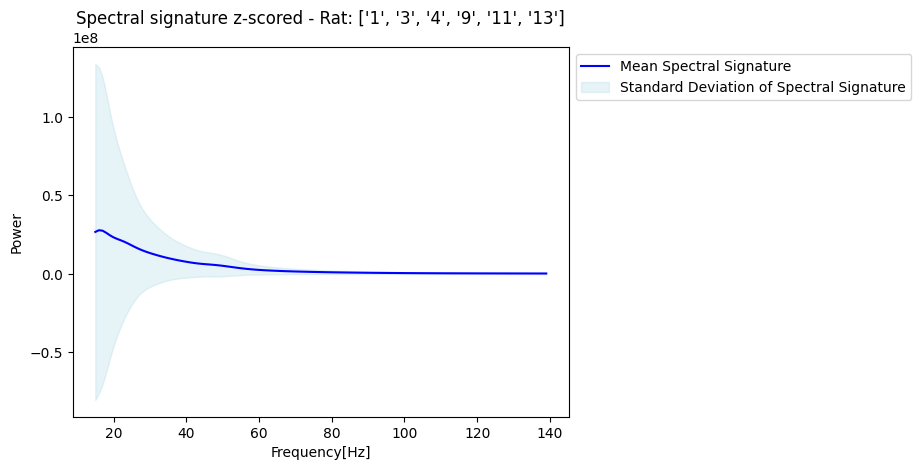

In [3]:
#Getting spectral signatures of all rats
# Define the root folder containing '1', '3','4', '6', '9', '11', '13' folders
root_folder = r"E:\Donders"

# Define the target folders
target_folders = ['1', '3','4', '9', '11', '13']
frequency_array = np.arange(15, 140, 1)
power_list = []
fpp_list = []

for target_folder in target_folders:
    # Construct the path to the processed folders
    processed_folder = os.path.join(root_folder, target_folder, 'processed')

    # Iterate through subfolders in processed folder
    for subfolder in os.listdir(processed_folder):
        subfolder_path = os.path.join(processed_folder, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Iterate through sub-subfolders (containing datasets)
            for dataset_folder in os.listdir(subfolder_path):
                dataset_folder_path = os.path.join(subfolder_path, dataset_folder)

                # Check if it's a directory
                if os.path.isdir(dataset_folder_path):
                    # Use glob to get all .h5 files in the dataset folder
                    hdf5_files = glob.glob(os.path.join(dataset_folder_path, '*.h5'))

                    # Iterate over each .h5 file
                    for hdf5_file_path in hdf5_files:
                        # Open the HDF5 file in read mode
                        with h5py.File(hdf5_file_path, 'r') as hdf_file:
                            # Iterate over all groups in the file
                            for group_name in hdf_file.keys():
                                # Access the current group
                                # Print debugging information
                                print(f"Processing file: {hdf5_file_path}")
                                print(f"Available groups: {list(hdf_file.keys())}")
                                current_group = hdf_file[group_name]
                                
                                # Continue with your processing for the current group
                                rem_dict_keys = list(current_group.keys())
                        

                                for rem_key in rem_dict_keys:
                                    # Access the 'IMFs' key to get the Intrinsic Mode Functions
                                    imfs = current_group[rem_key]['IMFs'] 
                                    print(imfs.shape)
                                    # Identify the indices of theta frequencies in the 'IMFs' array
                                    theta_range = (5, 12)
                                    sub_theta, theta, supra_theta = tg_split(current_group[rem_key]['IMF_Frequencies'], theta_range)

                                    # Extract IMFs corresponding to theta signals and sum them up
                                    supra_theta_imfs_sum = np.sum(imfs[:, supra_theta], axis=1)
 
                                    # Access the 'wavelet_transform' key for the current REM period
                                    wavelet_transform = morlet_wt(supra_theta_imfs_sum, 2500, frequency_array, n=5, mode='amplitude')
                                    # Square each value in the matrix to get power
                                    power_matrix = np.square(np.abs(wavelet_transform))
                                    print("shape power matrix:", power_matrix.shape)
                                    # Z-score along the time axis
                                    #power = zscore(power_matrix, axis=0)
                                
                                    start_end = hdf_file[group_name][rem_key]['start-end'][:]
                                    fpp_cycles = hdf_file[group_name][rem_key]['Cycles'][:]
                                    newcycles = fpp_cycles[:, [0, -1]] - start_end[0]

                                    # Calculate mean power values for the subset of frequencies
                                    fpp_plots = bin_tf_to_fpp(newcycles, power_matrix, 19)
                                    print("shape of fpp_plots", fpp_plots.shape)
                                    
                                    # Check if fpp_plots is 1D before attempting to calculate the mean along axis 2
                                    if len(fpp_plots.shape) > 1:
                                        fpp_list.append(fpp_plots)
                                        mean_along_axis_2 = (np.mean(fpp_plots, axis=2)).T
                                        print(mean_along_axis_2.shape)
                                        power_list.append(mean_along_axis_2)
                                        print("fpp_list length:", len(fpp_list))
                                    else:
                                        # Handle the case where fpp_plots is 1D (e.g., if there's an issue with the data)
                                        print("Error: Dimensions of fpp_plots are too small.")
combined_fpp = np.concatenate(fpp_list, axis=0)
print("combined_fpp shape is", combined_fpp.shape)
# Replace the original list comprehension for filtered_power_list
filtered_power_list = [arr for arr in power_list if len(arr.shape) > 0]

# Concatenate the filtered arrays
power_array = np.concatenate(filtered_power_list, axis=1)
print(power_array.shape)

# Calculate the mean power across all cycles
spectral_signature_mean = np.mean(power_array, axis=1)

# Calculate the standard deviation across all cycles (instead of standard error of the mean)
spectral_signature_std = np.std(power_array, axis=1)

# Plot the mean power across all cycles
plt.plot(frequency_array, spectral_signature_mean, linestyle='-', color='blue', label='Mean Spectral Signature')

# Fill the area between mean - std and mean + std with a translucent color
plt.fill_between(frequency_array, spectral_signature_mean - spectral_signature_std, spectral_signature_mean + spectral_signature_std, color='lightblue', alpha=0.3, label='Standard Deviation of Spectral Signature')

plt.xlabel('Frequency[Hz]')
plt.ylabel('Power')
plt.title(f'Spectral signature z-scored - Rat: {target_folders}')
# Place the legend outside of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()




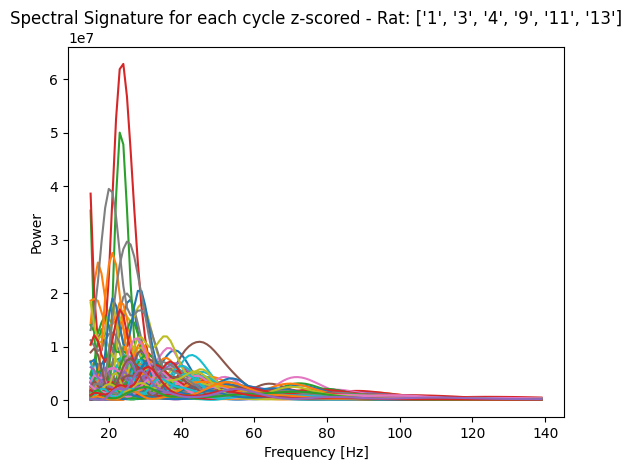

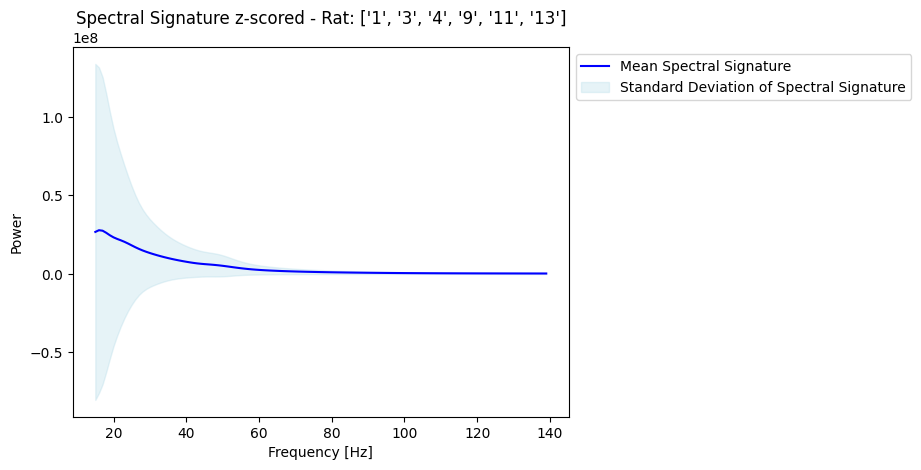

In [4]:
#Plotting the spectral signature of each cycle individually

# Plot each row in one plot
for i in range(power_array.shape[0]):
    plt.plot(frequency_array, power_array.T[i, :], label=f'Row {i + 1}')

# Add labels and legend
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title(f'Spectral Signature for each cycle z-scored - Rat: {target_folders}')

# Show the plot

plt.show()

# Calculate the mean power across all cycles
spectral_signature_mean = np.mean(power_array.T, axis=0)

# Calculate the standard deviation across all cycles (instead of standard error of the mean)
spectral_signature_std = np.std(power_array.T, axis=0)

# Plot the mean power across all cycles
plt.plot(frequency_array, spectral_signature_mean, linestyle='-', color='blue', label='Mean Spectral Signature')

# Fill the area between mean - std and mean + std with a translucent color
plt.fill_between(frequency_array, spectral_signature_mean - spectral_signature_std, spectral_signature_mean + spectral_signature_std, color='lightblue', alpha=0.3, label='Standard Deviation of Spectral Signature')

plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title(f'Spectral Signature z-scored - Rat: {target_folders}')

# Place the legend outside of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

np.save(r'E:\Donders\Weekly meeting\PCA_ICA\power_array_non_zscored.npy', power_array)

In [3]:
# Load the saved power array
power_array = np.load(r'E:\Donders\Weekly meeting\PCA_ICA\power_array_non_zscored.npy')

In [22]:
print(power_array.shape)

(125, 298536)


In [31]:
#PCA
seed=12
print(power_array.shape)
scaler = StandardScaler()
normalized_power_array = scaler.fit_transform(power_array)
pca=PCA(n_components=0.85,whiten=False,svd_solver='full', random_state=seed)
pcv=pca.fit_transform(normalized_power_array.T)#15-120Hz
print('Principal Component Analysis yields us '+str(pca.n_components_) + ' principal components')
print(pcv.shape)
#Explained variance ratio of ICA
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


(125, 298536)
Principal Component Analysis yields us 7 principal components
(298536, 7)
Explained Variance Ratio: [0.30364526 0.17377739 0.11621772 0.09652697 0.07424364 0.05650765
 0.04329121]


In [32]:
#ICA
ica = FastICA(n_components=pca.n_components_, whiten='unit-variance', random_state=seed)
icv = ica.fit_transform(power_array.T)
print(icv.shape)




(298536, 7)


In [33]:
#Classifying cycles into identified components

tSCs_median=np.median(icv,axis=0) # median(p)

print('tSC medians:'+ str(tSCs_median)+'\n')
mask=np.logical_and(icv>=tSCs_median,icv>0) # boolean values that satisfy |p-median(p)|
threshold=[]
for icvs,bl,tscmed in zip(icv.T,mask.T,tSCs_median):
    threshold.append(2*np.std(icvs[bl])+tscmed) # corrected code
thresholdmedian=np.array(threshold)
print('Calculated thresholds:'+str(thresholdmedian)+'\n')
tSCmask=icv>thresholdmedian #boolean array of satisfactory strong tSC components
for t,(icvT,tSCT) in enumerate(zip(icv.T,tSCmask.T)):
    print('#tSC'+str(t+1)+ ' cycles:'+str(icvT[tSCT].shape[0])+',\n')
print('Total number of tSC cycles detected: '+str(icv[tSCmask].shape[0]))

# Filter fpp_list based on the identified components
#filtered_fpp_list = [fpp_plot for fpp_plot, mask in zip(fpp_list, tSCmask) if len(fpp_plot.shape) > 0]
# Access fpp_plot for cycles within identified components
#fpp_plots_in_components = [fpp_plot[mask] for fpp_plot, mask in zip(filtered_fpp_list, tSCmask)]
#print(fpp_plots_in_components.shape)

tSC medians:[ 0.2426818  -0.07266377  0.18867109 -0.00447127 -0.12292442  0.16990767
  0.0143019 ]

Calculated thresholds:[0.82353844 3.67185564 1.24077503 1.90257376 4.49142692 0.94831729
 1.5010797 ]

#tSC1 cycles:9377,

#tSC2 cycles:2661,

#tSC3 cycles:5825,

#tSC4 cycles:4462,

#tSC5 cycles:1882,

#tSC6 cycles:5132,

#tSC7 cycles:10250,

Total number of tSC cycles detected: 39589


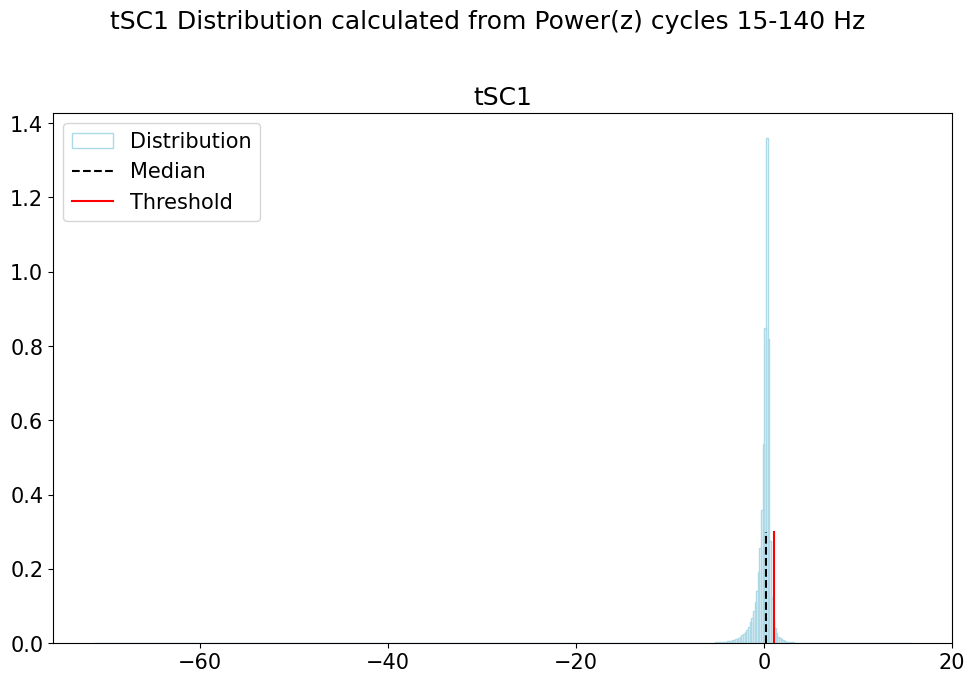

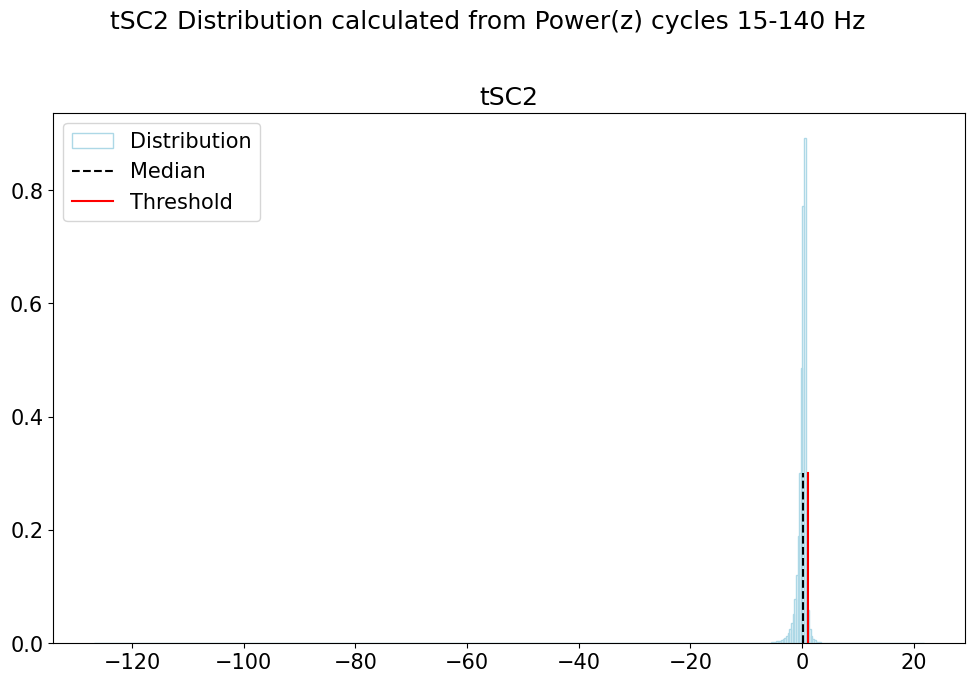

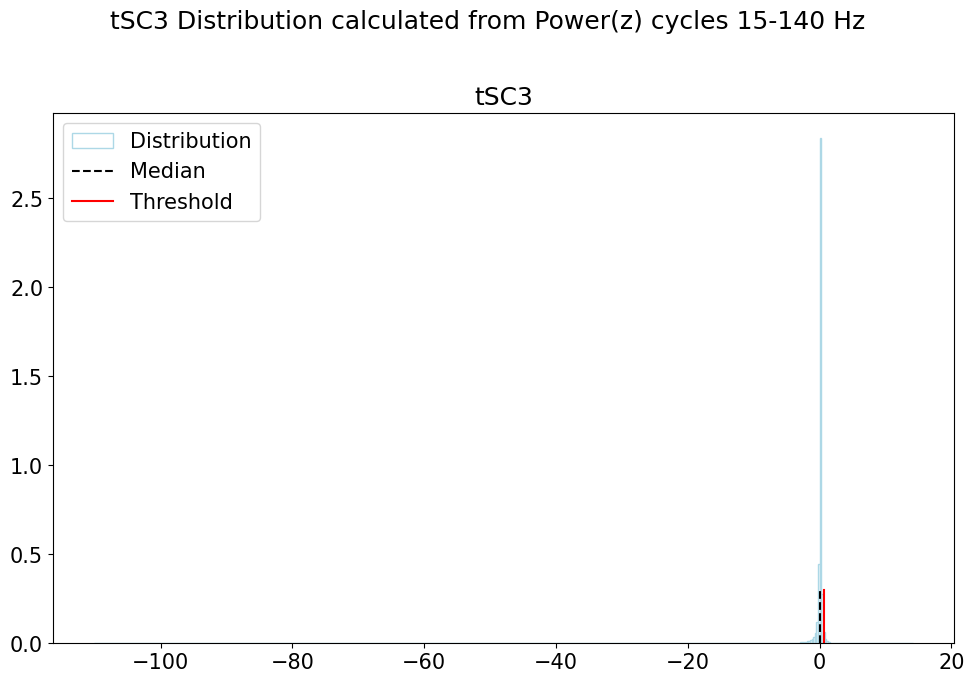

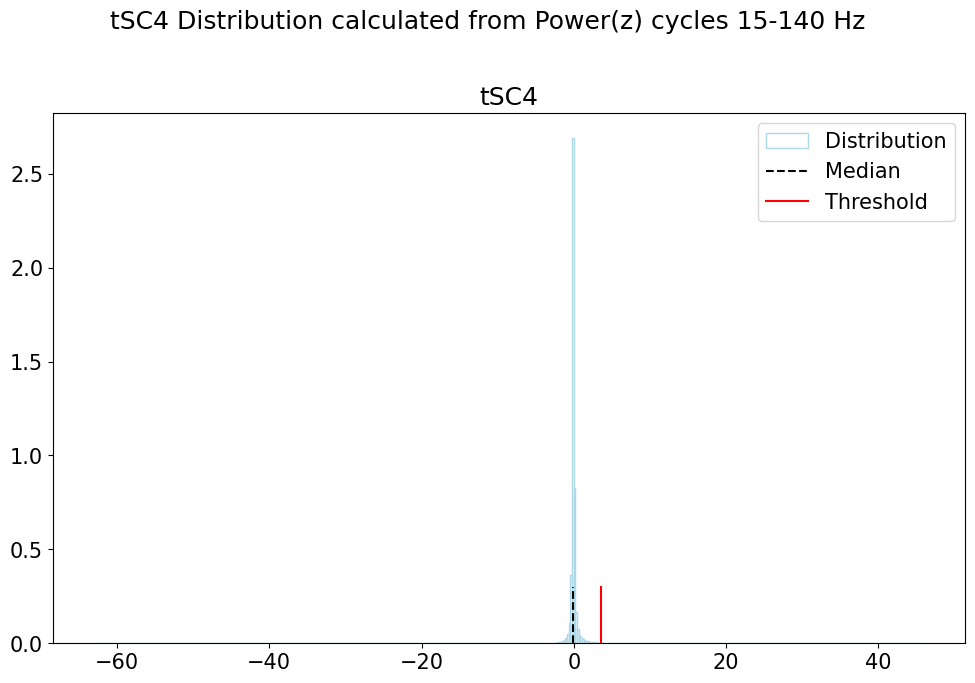

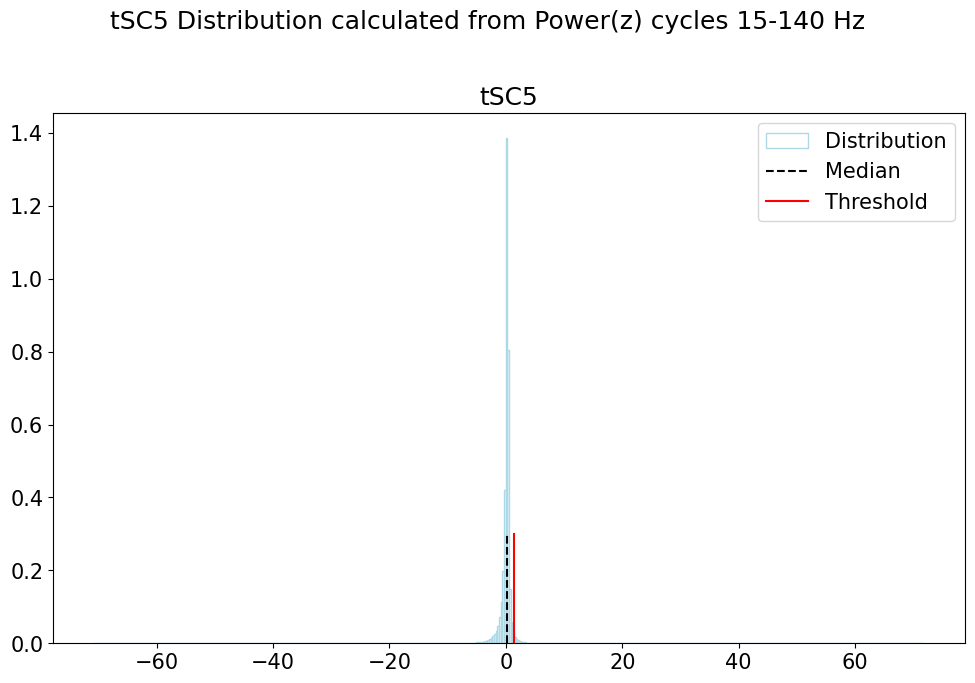

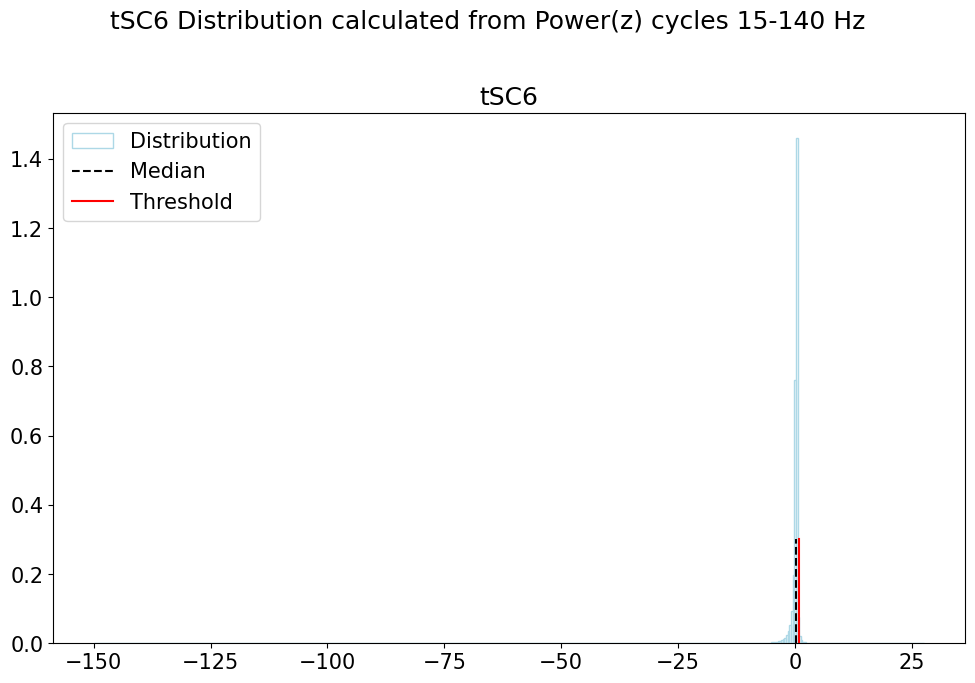

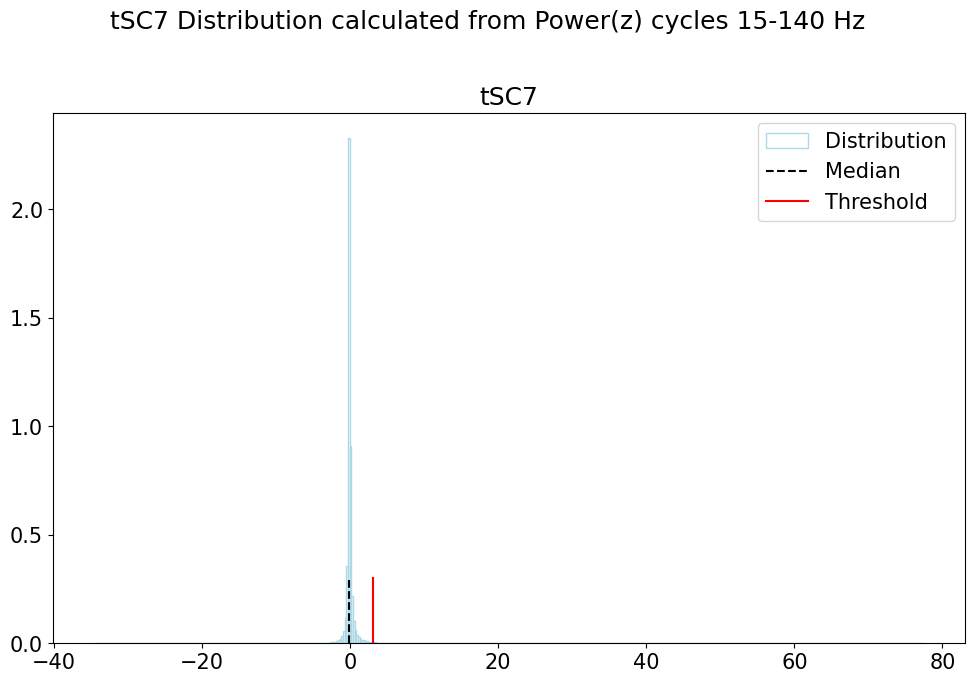

In [28]:
# Set the number of bins
n_bins = 500

# Set plot parameters
mediancolor = 'black'
medianlinestyle = 'dashed'
plt.rcParams.update({'font.size': 15})

# Create a legend labels list
legend_labels = ['Median', 'Threshold']

for i in range(icv.shape[1]):
    fig, ax = plt.subplots(figsize=(10, 7))
    fig.suptitle(f'tSC{i + 1} Distribution calculated from Power(z) cycles 15-140 Hz')
    
    # Plot histogram
    ax.hist(icv[:, i], bins=n_bins, histtype='bar', fill=False, density=True, edgecolor='lightblue', label='Distribution')
    
    # Plot median line
    ax.plot((np.median(icv[:, i]), np.median(icv[:, i])), (0, 0.3), color=mediancolor, linestyle='dashed', label=legend_labels[0])

    # Plot threshold line
    ax.plot((thresholdmedian[i], thresholdmedian[i]), (0, 0.3), color='red', label=legend_labels[1])

    ax.set_title(f'tSC{i + 1}')

    # Add legend
    ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # Show the plot
    plt.show()






(298536, 7)


Text(0.5, 1.0, 'tSC7')

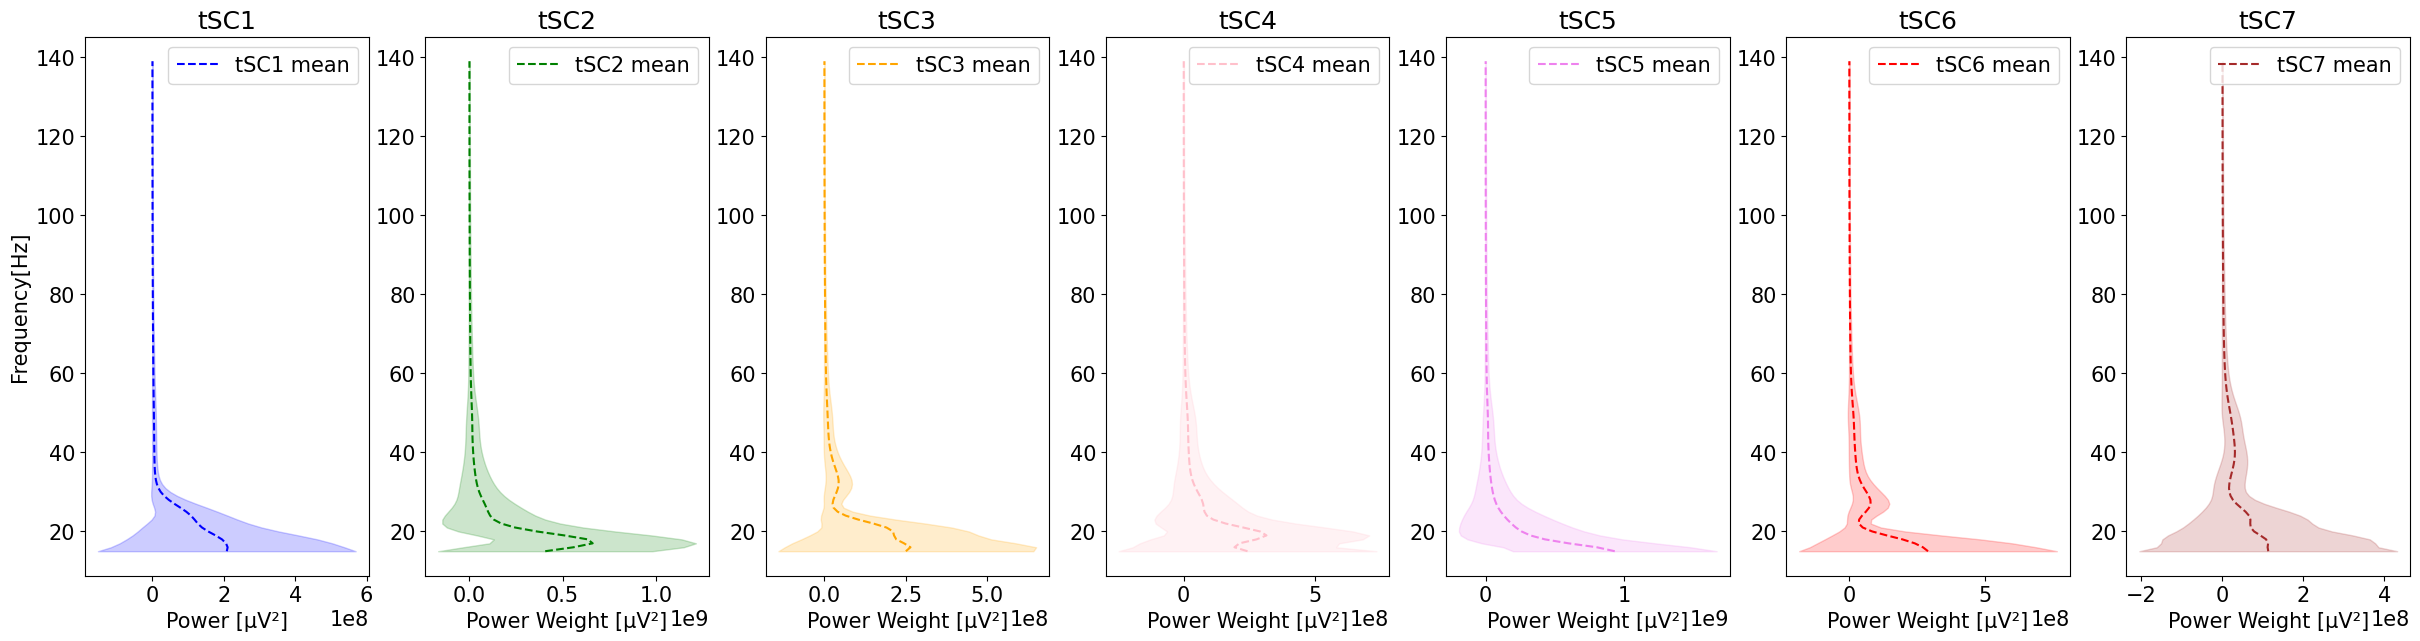

In [34]:
print(tSCmask.shape)
#@title Spectral Signatures of tSC cycles
tSC1=power_array.T[tSCmask.T[0]]
tSC2=power_array.T[tSCmask.T[1]]
tSC3=power_array.T[tSCmask.T[2]]
tSC4=power_array.T[tSCmask.T[3]]
tSC5=power_array.T[tSCmask.T[4]]
tSC6=power_array.T[tSCmask.T[5]]
tSC7=power_array.T[tSCmask.T[6]]



fig18,ax18=plt.subplots(1,icv.shape[1],figsize=(30,7))
plt.rcParams.update({'font.size': 15})
ax18[0].plot(tSC1.mean(axis=0),np.arange(15,140,1),color='blue',linestyle='dashed',
              label='tSC1 mean')
ax18[0].fill_betweenx(np.arange(15,140,1),
                       -tSC1.std(axis=0)+tSC1.mean(axis=0),
                       tSC1.std(axis=0)+tSC1.mean(axis=0),
                       alpha=0.2,color='blue')
ax18[0].set_xlabel('Power [μV²]')
ax18[0].set_ylabel('Frequency[Hz]')
ax18[0].legend(loc='upper right')
ax18[0].set_title('tSC1') 
ax18[1].plot(tSC2.mean(axis=0),np.arange(15,140,1),color='green',linestyle='dashed',
              label='tSC2 mean')
ax18[1].fill_betweenx(np.arange(15,140,1),
                       -tSC2.std(axis=0)+tSC2.mean(axis=0),
                       tSC2.std(axis=0)+tSC2.mean(axis=0),
                       alpha=0.2,color='green')
ax18[1].set_xlabel('Power Weight [μV²]')
#ax18[1].set_ylabel('Frequency')
ax18[1].legend(loc='upper right')
ax18[1].set_title('tSC2') 
ax18[2].plot(tSC3.mean(axis=0),np.arange(15,140,1),color='orange',linestyle='dashed',
              label='tSC3 mean')
ax18[2].fill_betweenx(np.arange(15,140,1),
                       -tSC3.std(axis=0)+tSC3.mean(axis=0),
                       tSC3.std(axis=0)+tSC3.mean(axis=0),
                       alpha=0.2,color='orange')
ax18[2].set_xlabel('Power Weight [μV²]')
#ax18[2].set_ylabel('Frequency')
ax18[2].legend(loc='upper right')
ax18[2].set_title('tSC3') 
ax18[3].plot(tSC4.mean(axis=0),np.arange(15,140,1),color='pink',linestyle='dashed',
              label='tSC4 mean')
ax18[3].fill_betweenx(np.arange(15,140,1),
                       -tSC4.std(axis=0)+tSC4.mean(axis=0),
                       tSC4.std(axis=0)+tSC4.mean(axis=0),
                       alpha=0.2,color='pink')
ax18[3].set_xlabel('Power Weight [μV²]')
#ax18[3].set_ylabel('Frequency')
ax18[3].legend(loc='upper right')
ax18[3].set_title('tSC4') 
ax18[4].plot(tSC5.mean(axis=0),np.arange(15,140,1),color='violet',linestyle='dashed',
              label='tSC5 mean')
ax18[4].fill_betweenx(np.arange(15,140,1),
                       -tSC5.std(axis=0)+tSC5.mean(axis=0),
                       tSC5.std(axis=0)+tSC5.mean(axis=0),
                       alpha=0.2,color='violet')
ax18[4].set_xlabel('Power Weight [μV²]')
#ax18[4].set_ylabel('Frequency')
ax18[4].legend(loc='upper right')
ax18[4].set_title('tSC5') 
ax18[5].plot(tSC6.mean(axis=0),np.arange(15,140,1),color='red',linestyle='dashed',
              label='tSC6 mean')
ax18[5].fill_betweenx(np.arange(15,140,1),
                       -tSC6.std(axis=0)+tSC6.mean(axis=0),
                       tSC6.std(axis=0)+tSC6.mean(axis=0),
                       alpha=0.2,color='red')
ax18[5].set_xlabel('Power Weight [μV²]')
#ax18[5].set_ylabel('Frequency')
ax18[5].legend(loc='upper right')
ax18[5].set_title('tSC6') 
ax18[6].plot(tSC7.mean(axis=0),np.arange(15,140,1),color='brown',linestyle='dashed',
              label='tSC7 mean')
ax18[6].fill_betweenx(np.arange(15,140,1),
                       -tSC7.std(axis=0)+tSC7.mean(axis=0),
                       tSC7.std(axis=0)+tSC7.mean(axis=0),
                       alpha=0.2,color='brown')
ax18[6].set_xlabel('Power Weight [μV²]')
#ax18[6].set_ylabel('Frequency')
ax18[6].legend(loc='upper right')
ax18[6].set_title('tSC7') 

In [117]:
import os
import glob
import h5py
import pandas as pd
import numpy as np

root_folder = r"E:\Donders"

# Define the target folders
target_folders = ['1', '3', '4', '9', '11', '13']
table_data = []

# Initialize an empty list to store the boolean mask for each file
tSCmask_list = []

for target_folder in target_folders:
    # Construct the path to the processed folders
    processed_folder = os.path.join(root_folder, target_folder, 'processed')

    # Iterate through subfolders in processed folder
    for subfolder in os.listdir(processed_folder):
        subfolder_path = os.path.join(processed_folder, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Iterate through sub-subfolders (containing datasets)
            for dataset_folder in os.listdir(subfolder_path):
                dataset_folder_path = os.path.join(subfolder_path, dataset_folder)

                # Check if it's a directory
                if os.path.isdir(dataset_folder_path):
                    # Use glob to get all .h5 files in the dataset folder
                    hdf5_files = glob.glob(os.path.join(dataset_folder_path, '*.h5'))

                    # Iterate over each .h5 file
                    for hdf5_file_path in hdf5_files:
                        # Open the HDF5 file in read mode
                        with h5py.File(hdf5_file_path, 'r') as hdf_file:
                            # Iterate over all groups in the file
                            for group_name in hdf_file.keys():
                                # Access the current group
                                current_group = hdf_file[group_name]

                                # Continue with your processing for the current group
                                rem_dict_keys = list(current_group.keys())

                                for rem_key in rem_dict_keys:
                                    # Check if 'Cycles' key exists and is not empty
                                    if 'Cycles' in current_group[rem_key] and len(current_group[rem_key]['Cycles']) > 0:
                                        # Access the 'Cycles' key to get the start and end indices
                                        cycles = current_group[rem_key]['Cycles']

                                        # Use NumPy operations to extract indices
                                        start_indices = np.array([cycle[0] for cycle in cycles])
                                        end_indices = np.array([cycle[-1] for cycle in cycles])

                                        # Append data to table_data
                                        table_data.extend([(target_folder, subfolder, dataset_folder, rem_key, start, end) for start, end in zip(start_indices, end_indices)])

                                        # Assuming tSCmask is calculated here and has the shape (len(start_indices), 7)
                                        # Modify this line based on how tSCmask is obtained in your code
                                        tSCmask_list.append(tSCmask)

# Create a DataFrame from the collected data
columns = ['RatNumber', 'BehavioralMode', 'DatasetName', 'REM', 'StartIndex', 'EndIndex']
df = pd.DataFrame(table_data, columns=columns)

# Determine the number of components
num_components = tSCmask.shape[1]

# Generate column names dynamically
column_names = [f'tSC{i}' for i in range(1, num_components + 1)]

# Concatenate tSCmask with the existing DataFrame
df_with_mask = pd.concat([df, pd.DataFrame(tSCmask, columns=column_names)], axis=1)

# Add a new column to indicate if multiple tSCs are True for each cycle
df_with_mask['MultipleTrue'] = df_with_mask.iloc[:, -num_components:].sum(axis=1) > 1

# Check if there are cycles with True values in multiple tSCs
cycles_with_multiple_true = df_with_mask[df_with_mask['MultipleTrue']]

# Print the cycles with True values in multiple tSCs
print("Cycles with True values in multiple tSCs:")
print(cycles_with_multiple_true[['RatNumber', 'BehavioralMode', 'DatasetName', 'REM', 'StartIndex', 'EndIndex']])

csv_filename = r"E:\Donders\df4_table_all_rats_with_mask.csv"
df_with_mask.to_csv(csv_filename, index=True, sep='\t', encoding='utf-8')

# Print the DataFrame with the added columns
print(df_with_mask)



Cycles with True values in multiple tSCs:
       RatNumber                                  BehavioralMode  \
11717          1                                              CN   
11821          1                                              CN   
18648          1                                              HC   
20107          1                                              HC   
24012          1                                              OD   
...          ...                                             ...   
298424        13  Rat_OS_Ephys_Rat13_344994_SD4_OD_21-22_05_2019   
298440        13  Rat_OS_Ephys_Rat13_344994_SD4_OD_21-22_05_2019   
298479        13  Rat_OS_Ephys_Rat13_344994_SD4_OD_21-22_05_2019   
298482        13  Rat_OS_Ephys_Rat13_344994_SD4_OD_21-22_05_2019   
298492        13  Rat_OS_Ephys_Rat13_344994_SD4_OD_21-22_05_2019   

                            DatasetName    REM  StartIndex  EndIndex  
11717   post_trial5_2017-09-28_14-55-18  REM 9    14395316  14395613  